In [1]:
import numpy as np 
import pandas as pd 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("ggplot")
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing

In [2]:
data = pd.read_excel('/kaggle/input/basket-analysis/Basket Analysis - Data.xlsx')
data.head()

,Transaction Date,Customer ID,Product Description
0,2014-01-01,1249,citrus fruit
1,2014-01-01,1249,coffee
2,2014-01-01,1249,italian sausage
3,2014-01-01,1249,sausage
4,2014-01-01,1381,curd


In [3]:
data["Customer ID"].nunique(),data["Customer ID"].unique()

(3898, array([1249, 1381, 1440, ..., 4755, 1963, 4565]))

In [4]:
data["Product Description"].nunique()

170

In [5]:
ID=data["Customer ID"].unique()
ID.tolist()
ID.sort()

In [6]:
item=data.groupby('Customer ID')['Product Description'].apply(list)
items=[]
for i in range(3898):
    items.append(item.iloc[i])
basket=pd.DataFrame({"item":ID,"products":items})
basket['products'] = basket['products'].astype(str)
regex = r'[\[\]/,]'
basket['products'] = basket['products'].apply(lambda x: re.sub(regex, '', x))
basket.head(2)

,item,products
0,1000,'pastry' 'salty snack' 'small milk' 'med milk'...
1,1001,'rollsbuns' 'sausage' 'small milk' 'med milk' ...


In [7]:
#concatenate multi-word product names together
basket['products'] = basket['products'].apply(lambda x: re.sub(r'(\w+)\s(\w+)', r'\1_\2', x))
basket

,item,products
0,1000,'pastry' 'salty_snack' 'small_milk' 'med_milk'...
1,1001,'rollsbuns' 'sausage' 'small_milk' 'med_milk' ...
2,1002,'frozen_vegetables' 'other_vegetables' 'butter...
3,1003,'dental_care' 'frozen_meals' 'sauces' 'rollsbu...
4,1004,'med_milk' 'pip_fruit' 'tropical_fruit' 'cling...
...,...,...
3893,4996,'salty_snack' 'tropical_fruit' 'bottled_beer' ...
3894,4997,'canned_beer' 'italian_sausage' 'large_milk' '...
3895,4998,'curd' 'rollsbuns'
3896,4999,'herbs' 'newspapers' 'semi-finished_bread' 'de...


In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(data):
    preprocessed_data = []
    for products in data:
        products = products.split()
        products = [lemmatizer.lemmatize(p) for p in products if p not in stop_words]
        preprocessed_data.append(" ".join(products))
    return preprocessed_data
    
basket['products'] = preprocess(basket['products'])


****

# Modeling

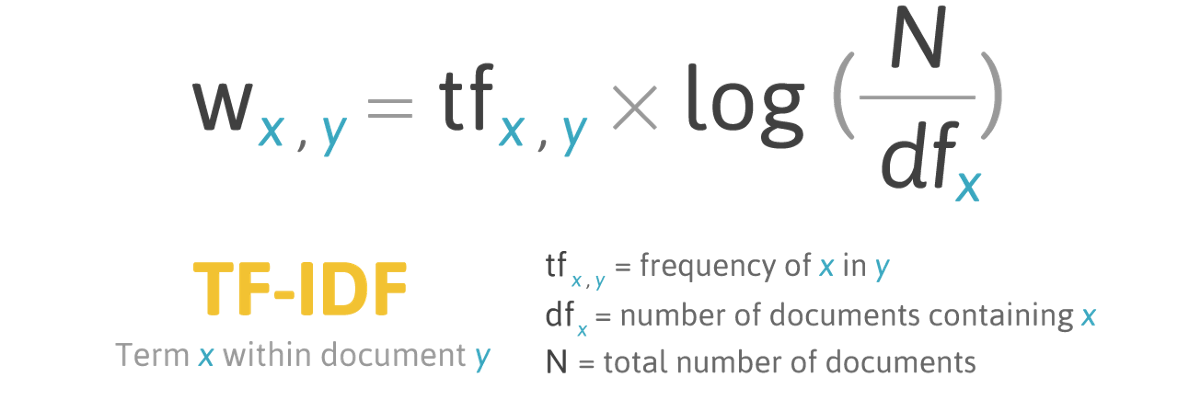

Jaccard similarity is a measure of similarity between two sets, it is defined as the size of the intersection divided by the size of the union of the sets. Jaccard similarity is commonly used for binary data, as it only considers whether an element is present or not in the sets, and it is insensitive to the frequency of the element

In our case, since we are trying to calculate the affinity of product in grocery sales, I would recommend using Jaccard similarity, it is a measure that is suited for your binary data, and would give you a good idea about the relationship between products in sales.

In [9]:
def jaccard_similarity(matrix):
    # Compute the Jaccard similarity between all pairs of products
    n_products = matrix.shape[1]
    jaccard_similarities = np.zeros((n_products, n_products))
    for i in range(n_products):
        for j in range(i, n_products):
            intersection = np.sum(matrix[:, i] & matrix[:, j])
            union = np.sum(matrix[:, i] | matrix[:, j])
            jaccard_similarities[i, j] = intersection / union
            jaccard_similarities[j, i] = jaccard_similarities[i, j]
    return jaccard_similarities

In [10]:
# Vectorize the data
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(basket['products']).toarray()
features = tfidf.get_feature_names_out()
tfidf_data = pd.DataFrame(tfidf_matrix, columns=features)
# Convert the tf-idf matrix to a binary matrix
binary_matrix = tfidf_matrix > 0
# Compute the Jaccard similarity between products
products_similarities = jaccard_similarity(binary_matrix)

from sklearn.cluster import AgglomerativeClustering
# n_clusters = 2

# Perform Hierarchical Clustering
agg =AgglomerativeClustering(n_clusters=None, distance_threshold=2.1)
agg.fit(products_similarities)

unique_labels = np.unique(agg.labels_)
print(len(unique_labels), "\n")

silhouette_avg =silhouette_score(tfidf_matrix.T, agg.labels_)
print("For n_clusters =", len(unique_labels), "The average silhouette_score is :", silhouette_avg,"\n\n")


# for i in unique_labels:
#     indices = np.where(agg.labels_ == i)[0]
#     print("Cluster {}: {}".format(i+1, ', '.join(np.array(tfidf.get_feature_names())[indices].tolist())))
#     print("\n\n")

9 

For n_clusters = 9 The average silhouette_score is : -0.17708387221006858 




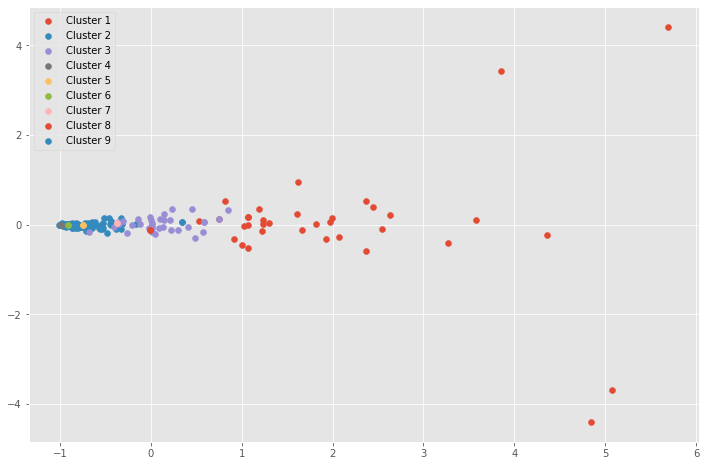

In [11]:
# Reduce the dimensionality of the data to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.T)

# Plot the results
plt.figure(figsize=(12,8))

for i in unique_labels:
    indices = np.where(agg.labels_ == i)[0]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Cluster {i+1}')
#     for j, product in enumerate(np.array(tfidf.get_feature_names())[indices.tolist()]):
#         plt.annotate(product, (pca_result[indices, 0][j], pca_result[indices, 1][j]))
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


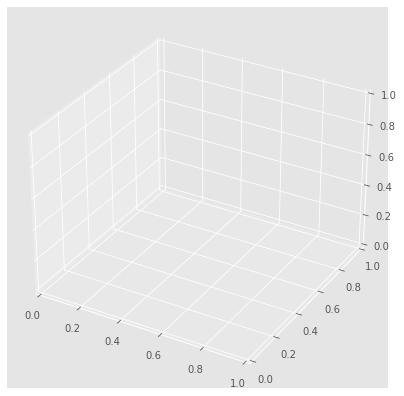

In [12]:
import plotly.colors
import plotly.graph_objs as go
# Reduce the dimensionality of the data to 2D
pca = PCA(n_components=3)
pca_result = pca.fit_transform(tfidf_matrix.T)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')
offset = 0.1
data = []
for i in unique_labels:
    indices = np.where(agg.labels_ == i)[0]
    trace = go.Scatter3d(x=pca_result[indices, 0], y=pca_result[indices, 1], z=pca_result[indices, 2], mode='markers',
    marker=dict(size=10, color=plotly.colors.DEFAULT_PLOTLY_COLORS[i]),
    text=[tfidf.get_feature_names()[i] for i in indices],
    name=f'Cluster {i+1}')
    data.append(trace)


layout = go.Layout(title='3D Plot',scene=dict(xaxis=dict(title='PC1'), yaxis=dict(title='PC2'), zaxis=dict(title='PC3')))
fig = go.Figure(data=data, layout=layout)
fig.show()

****

In [13]:
df_transposed = tfidf_data.transpose()
df_transposed.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3888,3889,3890,3891,3892,3893,3894,3895,3896,3897
abrasive_cleaner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.484943,0.0,0.0,0.0,0.0,0.0,0.0,0.0
appetizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393053,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
artif,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
baby_cosmetics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bags,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from sklearn.metrics import pairwise_distances
# Perform k-means clustering
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters,random_state=0)
kmeans.fit(df_transposed)

# Get the cluster assignments for each product
clusters = kmeans.predict(df_transposed)

# Add the cluster assignments as a new column in the dataframe
# df_transposed["cluster"] = clusters

# Compute the similarity between products
products_similarities = 1 - pairwise_distances(df_transposed, metric="cosine")

unique_labels = np.unique(clusters)
print(len(unique_labels), "\n")

silhouette_avg =silhouette_score(df_transposed, clusters)
print("For n_clusters =", len(unique_labels), "The average silhouette_score is :", silhouette_avg,"\n\n")

# Print the products in each cluster
for i in range(n_clusters):
    indices = np.where(kmeans.labels_ == i)[0]
    print("Cluster {}: {}".format(i+1, ', '.join(df_transposed.index[indices].tolist())))
    print("\n\n")



9 

For n_clusters = 9 The average silhouette_score is : 0.24142291017007814 


Cluster 1: abrasive_cleaner, appetizer, artif, baby_cosmetics, bags, bakery_product, baking_powder, bathroom_cleaner, berries, beverages, bottled_beer, bottled_water, brandy, brown_bread, butter, butter_milk, cake_bar, candles, candy, canned_beer, canned_fish, canned_fruit, canned_vegetables, cat_food, cereals, chewing_gum, chicken, chocolate, chocolate_marshmallow, citrus_fruit, cleaner, cling_filmbags, cocoa_drinks, coffee, condensed_milk, cooking_chocolate, cookware, cream, cream_cheese, curd, curd_cheese, decalcifier, delete, dental_care, dessert, detergent, dish_cleaner, dishes, dog_food, domestic_eggs, female_sanitary, finished_bread, finished_products, fish, flour, flower, flower_soilfertilizer, frozen_chicken, frozen_dessert, frozen_fish, frozen_fruits, frozen_meals, frozen_potato, frozen_vegetables, fruitvegetable_juice, grapes, hair_spray, ham, hamburger_meat, hard_cheese, herbs, honey, house_keep

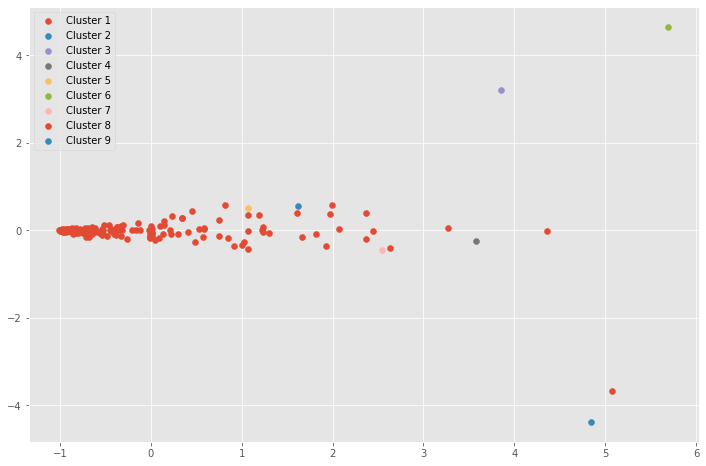

In [15]:
# Reduce the dimensionality of the data to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_transposed)

# Plot the results
plt.figure(figsize=(12,8))
for i in range(n_clusters):
    indices = np.where(kmeans.labels_ == i)[0]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Cluster {i+1}')
#     for j, product in enumerate(np.array(tfidf.get_feature_names())[indices.tolist()]):
#         plt.annotate(product, (pca_result[indices, 0][j], pca_result[indices, 1][j]))
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



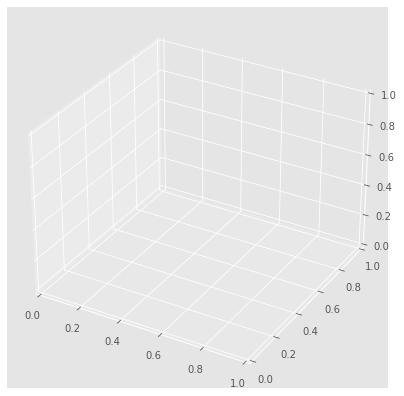

In [16]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_transposed)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')
offset = 0.1
data = []
for i in unique_labels:
    indices = np.where(kmeans.labels_ == i)[0]
    trace = go.Scatter3d(x=pca_result[indices, 0], y=pca_result[indices, 1], z=pca_result[indices, 2], mode='markers',
    marker=dict(size=10, color=plotly.colors.DEFAULT_PLOTLY_COLORS[i]),
    text=[tfidf.get_feature_names()[i] for i in indices],
    name=f'Cluster {i+1}')
    data.append(trace)


layout = go.Layout(title='3D Plot',scene=dict(xaxis=dict(title='PC1'), yaxis=dict(title='PC2'), zaxis=dict(title='PC3')))
fig = go.Figure(data=data, layout=layout)
fig.show()

# XAI

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
kmeanModel = KMeans(n_clusters=9)
y=kmeanModel.fit(df_transposed).labels_
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8])
clf=RandomForestClassifier()
clf.fit(df_transposed,y)

RandomForestClassifier()

In [18]:
import shap
explainer= shap.TreeExplainer(clf)
shap_values = explainer(df_transposed).values

In [19]:
shap_values.shape

(177, 3898, 18)

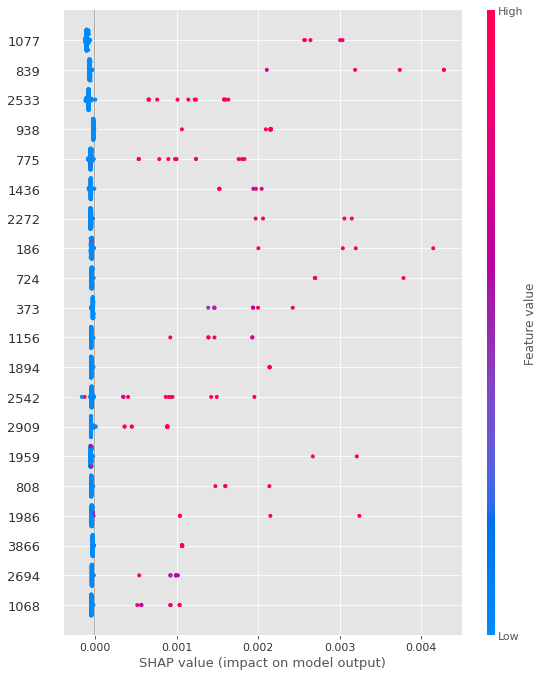

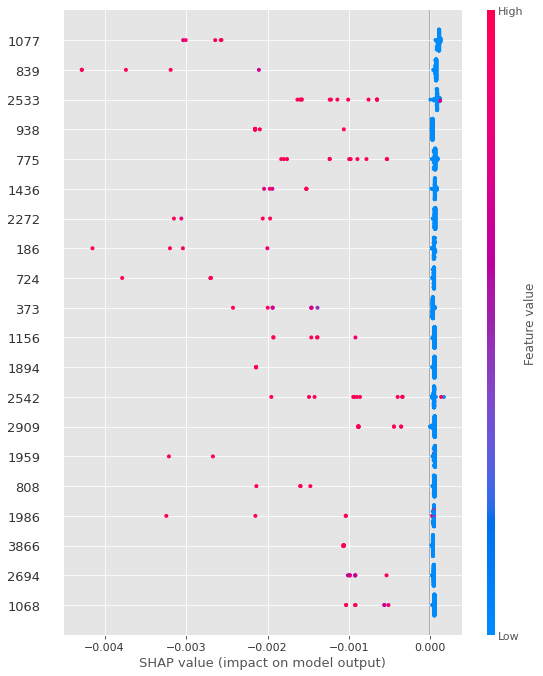

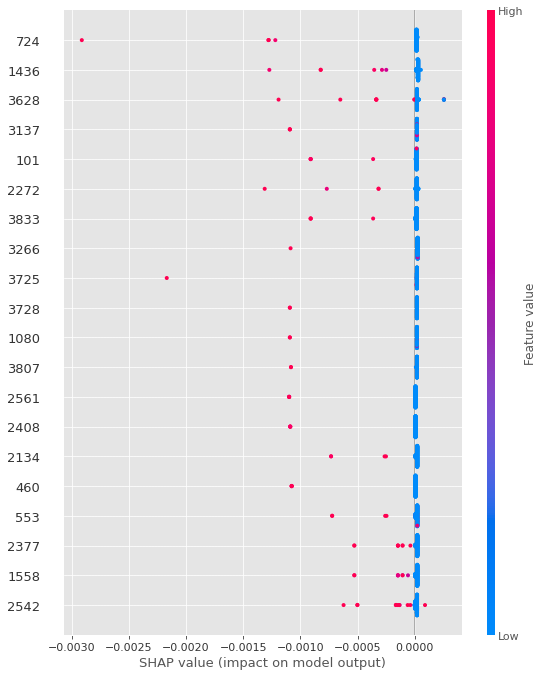

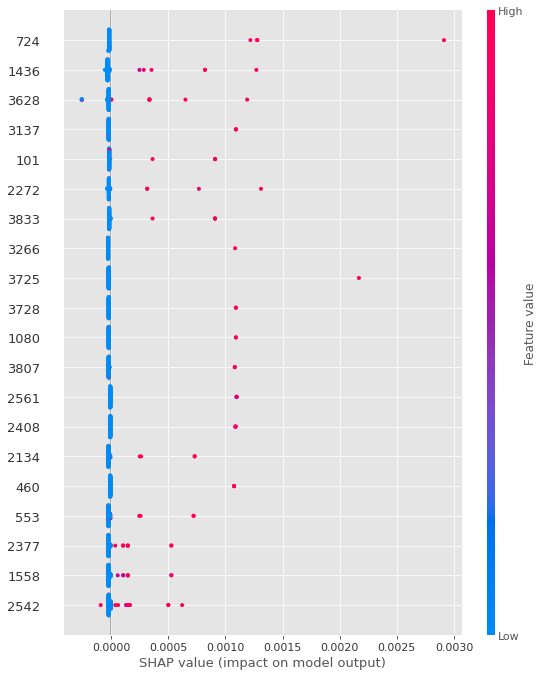

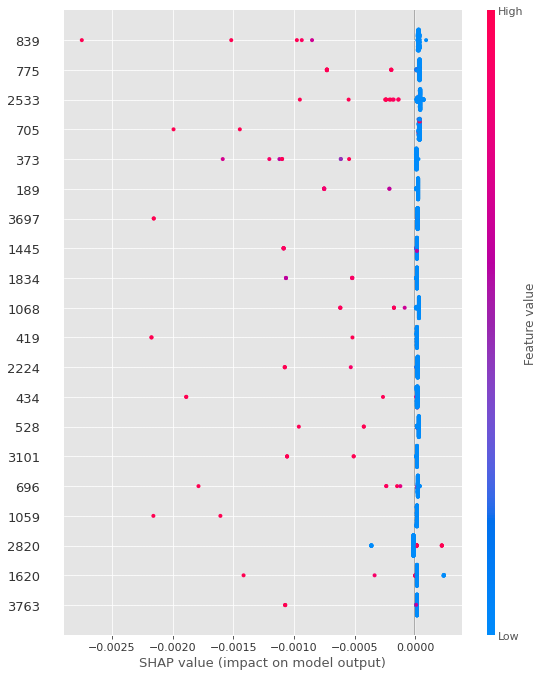

In [20]:
df_transposed.index = df_transposed.index.astype(str)
for i in range(5):
    shap.summary_plot(shap_values[:,:,i], df_transposed)